# Capston Project 3 - The Financial Performance of the ESG Funds <a class="tocSkip">
# Modeling and Evaluation <a class="tocSkip">
By Tingyin Xiao

<a id="0"></a> <br>
 # Table of Contents  <a class="tocSkip">

* [1. Introduction](#1)
* [2. Importing the Dependencies](#2)
* [3. Uploading and Preprocessing the Data](#3)
    * [3.1. For ARIMA Model](#3.1)
    * [3.2. For Regression Models](#3.2)
* [4  Building the Function for ARIMA Model](#4)
* [5  Building the Functions for Random Forest Model](#5)
    * [5.1. Make a Function of the Regression Problem](#5.1)
    * [5.2. Make a Function to Apply Regression Algorithms on the Problem](#5.2)
    * [5.3. Apply the Functions on the Time Series](#5.3)
    * [5.4. Compare the Results to ARIMA Model](#5.4)
* [6. Summary](#6)

<a id="1"></a> 
## Introduction

In the data preprocessing and modeling exploration section, we applied ARIMA and Random Forest models on a single time series prediction, without and with features. In this section, we will build functions for the time series predictions based on these models and apply them to a randomly selected example subset of the whole dataset. The model performances are evaluated and compared. We will discuss the results and future development in the summary.

[Back to the Table of Contents](#0)

<a id="2"></a> 
## Loading the dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import random

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
import sklearn
sklearn.__version__ # '1.0.2'

'1.0.2'

[Back to the Table of Contents](#0)

<a id="3"></a> 
## Uploading and Preprocessing the Data

As an example, we would like to apply all the algorithms to randomly selected ten time series. For the ARIMA model, we only need the time series as input. As for the Random Forest model, we will also need corresponding features, including the lagging features. 

<a id="3.1"></a> 
### For ARIMA Model

In [3]:
# Import the imputed time series data

data = pd.read_csv('data/imputed_time_series_data.csv', index_col = 'Financial performance as-of date', parse_dates = True)

In [4]:
data.head()

,Shareclass_name,"Month end trailing returns, 1 year"
Financial performance as-of date,,
2020-03-31,1919 Socially Responsive Balanced A,0.00352
2020-04-30,1919 Socially Responsive Balanced A,5.60674
2020-05-31,1919 Socially Responsive Balanced A,13.11467
2020-06-30,1919 Socially Responsive Balanced A,10.91060
2020-07-31,1919 Socially Responsive Balanced A,15.01209


In [5]:
# randomly choose 10 time series
length = 33                # each time series has 33 time steps 
random.seed(42)
n = int(len(data)/length)  # total number of times series
index = [random.randint(0, n-1) for _ in range(10)]
print(index)
shareclass_list = data['Shareclass_name'].unique()[index]
print(shareclass_list)
ts_10 = data[data['Shareclass_name'].isin(shareclass_list)]
ts_10.head()

[5238, 912, 204, 2253, 2006, 1828, 1143, 839, 5543, 4467]
['Vanguard Value Index I' 'Brown Advisory Sustainable Growth Adv'
 'American Century Equity Income Inv' 'Franklin Utilities Adv'
 'First Eagle Global I' 'Fidelity Growth & Income K'
 'Columbia Emerging Markets Adv' 'BlackRock Global Dividend Inv A'
 'iShares Russell Top 200 ETF' 'SEI Tax-Managed Large Cap F (SIMT)']


,Shareclass_name,"Month end trailing returns, 1 year"
Financial performance as-of date,,
2020-03-31,American Century Equity Income Inv,-11.80991
2020-04-30,American Century Equity Income Inv,-6.23196
2020-05-31,American Century Equity Income Inv,-0.13612
2020-06-30,American Century Equity Income Inv,-5.31679
2020-07-31,American Century Equity Income Inv,-3.17459


In [6]:
len(ts_10)

330

[Back to the Table of Contents](#0)

<a id="3.2"></a> 
### For Regression Models

In [7]:
# Import the dataframe with all features that have less than 10% missing data

df = pd.read_csv('data/shareclasses_one_year_return_max_months_less_than_10pct_missing.csv', index_col = 'Financial performance as-of date', parse_dates = True)

In [8]:
# There are two months systematically missing in all the time series
# Merging the imputed 10 selected time series in the previous section with the dataframe including features

data_df = pd.merge(ts_10.reset_index(), df.reset_index(), 
                  left_on = ['Financial performance as-of date', 'Shareclass_name'], 
                  right_on = ['Financial performance as-of date', 'Shareclass name'], 
                  how = 'left') 
data_df = data_df.set_index(['Shareclass_name', 'Financial performance as-of date'])
data_df.head()

Month end trailing returns, 1 year_x  \
Shareclass_name                    Financial performance as-of date                                         
American Century Equity Income Inv 2020-03-31                                                   -11.80991   
                                   2020-04-30                                                    -6.23196   
                                   2020-05-31                                                    -0.13612   
                                   2020-06-30                                                    -5.31679   
                                   2020-07-31                                                    -3.17459   

                                                                          Fund profile: Shareclass name  \
Shareclass_name                    Financial performance as-of date                                       
American Century Equity Income Inv 2020-03-31                        American Century Equity Income Inv   
                                   2020-04-30                        American Century Equity Income Inv   
                                   2020-05-31                        American Century Equity Income Inv   
                                   2020-06-30                        American Century Equity Income Inv   
                                   2020-07-31                        American Century Equity Income Inv   

                                                                    Fund profile: Ticker  \
Shareclass_name                    Financial performance as-of date                        
American Century Equity Income Inv 2020-03-31                                      AEURX   
                                   2020-04-30                                      AEUDX   
                                   2020-05-31                                      ACIIX   
                                   2020-06-30                                      ACIIX   
                                   2020-07-31                                      TWEIX   

                                                                                 Fund profile: Fund name  \
Shareclass_name                    Financial performance as-of date                                        
American Century Equity Income Inv 2020-03-31                        American Century Equity Income Fund   
                                   2020-04-30                        American Century Equity Income Fund   
                                   2020-05-31                        American Century Equity Income Fund   
                                   2020-06-30                        American Century Equity Income Fund   
                                   2020-07-31                        American Century Equity Income Fund   

                                                                      Fund profile: Asset manager  \
Shareclass_name                    Financial performance as-of date                                 
American Century Equity Income Inv 2020-03-31                        American Century Investments   
                                   2020-04-30                        American Century Investments   
                                   2020-05-31                        American Century Investments   
                                   2020-06-30                        American Century Investments   
                                   2020-07-31                        American Century Investments   

                                                                    Fund profile: Shareclass type  \
Shareclass_name                    Financial performance as-of date                                 
American Century Equity Income Inv 2020-03-31                                Open-end mutual fund   
                                   2020-04-30                                Open-end mutual fund   
                                   2020-0

In [9]:
# Checking the target variables

df_target =data_df.filter(like = 'returns')
df_target.head()

Month end trailing returns, 1 year_x  \
Shareclass_name                    Financial performance as-of date                                         
American Century Equity Income Inv 2020-03-31                                                   -11.80991   
                                   2020-04-30                                                    -6.23196   
                                   2020-05-31                                                    -0.13612   
                                   2020-06-30                                                    -5.31679   
                                   2020-07-31                                                    -3.17459   

                                                                     Month end trailing returns, 1 year_y  \
Shareclass_name                    Financial performance as-of date                                         
American Century Equity Income Inv 2020-03-31                                                   -11.80991   
                                   2020-04-30                                                    -6.23196   
                                   2020-05-31                                                    -0.13612   
                                   2020-06-30                                                    -5.31679   
                                   2020-07-31                                                    -3.17459   

                                                                     Month end trailing returns, 3 year  \
Shareclass_name                    Financial performance as-of date                                       
American Century Equity Income Inv 2020-03-31                                                   0.52713   
                                   2020-04-30                                                   3.46481   
                                   2020-05-31                                                   4.15704   
                                   2020-06-30                                                   3.93204   
                                   2020-07-31                                                   4.56894   

                                                                     Month end trailing returns, 5 year  
Shareclass_name                    Financial performance as-of date                                      
American Century Equity Income Inv 2020-03-31                                                   4.90839  
                                   2020-04-30                                                   6.66072  
                                   2020-05-31                                                   7.13069  
                                   2020-06-30                                                   7.70082  
                                   2020-07-31                                                   8.14481

In [10]:
# Define the target

target = data_df['Month end trailing returns, 1 year_x']
target.head()

Shareclass_name                     Financial performance as-of date
American Century Equity Income Inv  2020-03-31                         -11.80991
                                    2020-04-30                          -6.23196
                                    2020-05-31                          -0.13612
                                    2020-06-30                          -5.31679
                                    2020-07-31                          -3.17459
Name: Month end trailing returns, 1 year_x, dtype: float64

In [11]:
# Only keep the columns with Pandas dtype 'object' 

categorical_columns = data_df.select_dtypes(include=['object']).columns
ts_catx = data_df[categorical_columns]

In [12]:
# The only missing dates are 2020-11-30 and 2021-04-30 for all the data columns and all the share classes. 
# we cannot use numerical imputation methods like mean or maximum for 'object' dtypes.
# Imputing the missing values with forward fill, based on the assumption that the missed values are unchanged from the previous date. 

ts_catx_filled = ts_catx.ffill()
ts_catx_filled.head()

Fund profile: Shareclass name  \
Shareclass_name                    Financial performance as-of date                                       
American Century Equity Income Inv 2020-03-31                        American Century Equity Income Inv   
                                   2020-04-30                        American Century Equity Income Inv   
                                   2020-05-31                        American Century Equity Income Inv   
                                   2020-06-30                        American Century Equity Income Inv   
                                   2020-07-31                        American Century Equity Income Inv   

                                                                    Fund profile: Ticker  \
Shareclass_name                    Financial performance as-of date                        
American Century Equity Income Inv 2020-03-31                                      AEURX   
                                   2020-04-30                                      AEUDX   
                                   2020-05-31                                      ACIIX   
                                   2020-06-30                                      ACIIX   
                                   2020-07-31                                      TWEIX   

                                                                                 Fund profile: Fund name  \
Shareclass_name                    Financial performance as-of date                                        
American Century Equity Income Inv 2020-03-31                        American Century Equity Income Fund   
                                   2020-04-30                        American Century Equity Income Fund   
                                   2020-05-31                        American Century Equity Income Fund   
                                   2020-06-30                        American Century Equity Income Fund   
                                   2020-07-31                        American Century Equity Income Fund   

                                                                      Fund profile: Asset manager  \
Shareclass_name                    Financial performance as-of date                                 
American Century Equity Income Inv 2020-03-31                        American Century Investments   
                                   2020-04-30                        American Century Investments   
                                   2020-05-31                        American Century Investments   
                                   2020-06-30                        American Century Investments   
                                   2020-07-31                        American Century Investments   

                                                                    Fund profile: Shareclass type  \
Shareclass_name                    Financial performance as-of date                                 
American Century Equity Income Inv 2020-03-31                                Open-end mutual fund   
                                   2020-04-30                                Open-end mutual fund   
                                   2020-05-31                                Open-end mutual fund   
                                   2020-06-30                                Open-end mutual fund   
                                   2020-07-31                                Open-end mutual fund   

                                                                    Fund profile: Shareclass inception date  \
Shareclass_name                    Financial performance as-of date                                           
American Century Equity Income Inv 2020-03-31                                                    1994-08-01   
                                   2020-04-30                                                    1994-08-01   
                                   2020-05-31                 

In [13]:
# To simplify the first model attempt, we only keep the ESG grade variables

ts_catx_grade = ts_catx_filled.filter(like = 'grade')
grade_columns = ts_catx_grade.columns

In [14]:
# Dealing with ordinal categories of the grade variables
# First define the shared ordinal categories

ordinal_categories = list(pd.Series(ts_catx_grade.values.ravel()).unique())
print(ordinal_categories)

['F', 'B', 'A', 'D', 'C']


In [15]:
type(grade_columns)

pandas.core.indexes.base.Index

In [16]:
ts_catx_esg = ts_catx_filled[grade_columns.tolist()]

In [17]:
ts_catx_esg.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 330 entries, ('American Century Equity Income Inv', Timestamp('2020-03-31 00:00:00')) to ('iShares Russell Top 200 ETF', Timestamp('2022-11-30 00:00:00'))
Data columns (total 6 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   Fossil Free Funds: Fossil fuel grade           330 non-null    object
 1   Deforestation Free Funds: Deforestation grade  330 non-null    object
 2   Gender Equality Funds: Gender equality grade   330 non-null    object
 3   Gun Free Funds: Civilian firearm grade         330 non-null    object
 4   Weapon Free Funds: Military weapon grade       330 non-null    object
 5   Tobacco Free Funds: Tobacco grade              330 non-null    object
dtypes: object(6)
memory usage: 17.9+ KB


In [18]:
ts_catx_esg.head()

Fossil Free Funds: Fossil fuel grade  \
Shareclass_name                    Financial performance as-of date                                        
American Century Equity Income Inv 2020-03-31                                                          F   
                                   2020-04-30                                                          F   
                                   2020-05-31                                                          F   
                                   2020-06-30                                                          F   
                                   2020-07-31                                                          F   

                                                                    Deforestation Free Funds: Deforestation grade  \
Shareclass_name                    Financial performance as-of date                                                 
American Century Equity Income Inv 2020-03-31                                                                   B   
                                   2020-04-30                                                                   B   
                                   2020-05-31                                                                   B   
                                   2020-06-30                                                                   B   
                                   2020-07-31                                                                   B   

                                                                    Gender Equality Funds: Gender equality grade  \
Shareclass_name                    Financial performance as-of date                                                
American Century Equity Income Inv 2020-03-31                                                                  A   
                                   2020-04-30                                                                  A   
                                   2020-05-31                                                                  A   
                                   2020-06-30                                                                  A   
                                   2020-07-31                                                                  A   

                                                                    Gun Free Funds: Civilian firearm grade  \
Shareclass_name                    Financial performance as-of date                                          
American Century Equity Income Inv 2020-03-31                                                            B   
                                   2020-04-30                                                            B   
                                   2020-05-31                                                            B   
                                   2020-06-30                                                            B   
                                   2020-07-31                                                            B   

                                                                    Weapon Free Funds: Military weapon grade  \
Shareclass_name                    Financial performance as-of date                                            
American Century Equity Income Inv 2020-03-31                                                              A   
                                   2020-04-30                                                              A   
                                   2020-05-31                                                              A   
                                   2020-06-30                                                              A   
                                   2020-07-31                                                              F   

                                                                    Tobacco Free Funds: Tobacco grade  
Shareclass_name   

In [19]:
# Select the numeric features

numeric_columns = data_df.select_dtypes(include=['float', 'int']).columns
ts_num = data_df[numeric_columns]
ts_num.tail()

Month end trailing returns, 1 year_x  \
Shareclass_name             Financial performance as-of date                                         
iShares Russell Top 200 ETF 2022-07-31                                                    -5.93930   
                            2022-08-31                                                   -12.42459   
                            2022-09-30                                                   -16.55073   
                            2022-10-31                                                   -16.21483   
                            2022-11-30                                                   -11.35750   

                                                              Fund profile: Fund net assets  \
Shareclass_name             Financial performance as-of date                                  
iShares Russell Top 200 ETF 2022-07-31                                          842200635.0   
                            2022-08-31                                          803009352.0   
                            2022-09-30                                          737164538.0   
                            2022-10-31                                          785606115.0   
                            2022-11-30                                          917633254.0   

                                                              Fund profile: Percent rated  \
Shareclass_name             Financial performance as-of date                                
iShares Russell Top 200 ETF 2022-07-31                                           0.997761   
                            2022-08-31                                           0.996423   
                            2022-09-30                                           0.989196   
                            2022-10-31                                           0.997802   
                            2022-11-30                                           0.997081   

                                                              Fossil Free Funds: Fossil fuel holdings, count  \
Shareclass_name             Financial performance as-of date                                                   
iShares Russell Top 200 ETF 2022-07-31                                                                  20.0   
                            2022-08-31                                                                  20.0   
                            2022-09-30                                                                  20.0   
                            2022-10-31                                                                  20.0   
                            2022-11-30                                                                  20.0   

                                                              Fossil Free Funds: Fossil fuel holdings, weight  \
Shareclass_name             Financial performance as-of date                                                    
iShares Russell Top 200 ETF 2022-07-31                                                               0.085393   
                            2022-08-31                                                               0.088457   
                            2022-09-30                                                               0.088109   
                            2022-10-31                                                               0.095504   
                            2022-11-30                                                               0.094426   

                                                              Fossil Free Funds: Fossil fuel holdings, asset  \
Shareclass_name             Financial performance as-of date                                                   
iShares Russell Top 200 ETF 2022-07-31                                                            71931033.0   
                            2022-08-31                                                            71031980.0   
    

In [20]:
# Here, impute all the missing values by calculate the mean of the previous and after values 

# Checking the missing values
print(ts_num.isna().sum().max())
# Only missing values are the two months without records

ts_num_ffill = ts_num.ffill()
ts_num_bfill = ts_num.bfill()
ts_num_filled = ts_num.fillna((ts_num_ffill + ts_num_bfill) / 2)
ts_num_filled.isna().sum().max()

43


0

In [21]:
# Removing the target variables

ts_numx = ts_num_filled.drop(columns = df_target.columns)
ts_numx.head()

Fund profile: Fund net assets  \
Shareclass_name                    Financial performance as-of date                                  
American Century Equity Income Inv 2020-03-31                                         1.303380e+10   
                                   2020-04-30                                         1.001785e+10   
                                   2020-05-31                                         1.001785e+10   
                                   2020-06-30                                         1.001785e+10   
                                   2020-07-31                                         1.097035e+10   

                                                                     Fund profile: Percent rated  \
Shareclass_name                    Financial performance as-of date                                
American Century Equity Income Inv 2020-03-31                                           0.828708   
                                   2020-04-30                                           0.787239   
                                   2020-05-31                                           0.773155   
                                   2020-06-30                                           0.773155   
                                   2020-07-31                                           0.799007   

                                                                     Fossil Free Funds: Fossil fuel holdings, count  \
Shareclass_name                    Financial performance as-of date                                                   
American Century Equity Income Inv 2020-03-31                                                                  13.0   
                                   2020-04-30                                                                  13.0   
                                   2020-05-31                                                                  13.0   
                                   2020-06-30                                                                  13.0   
                                   2020-07-31                                                                  10.0   

                                                                     Fossil Free Funds: Fossil fuel holdings, weight  \
Shareclass_name                    Financial performance as-of date                                                    
American Century Equity Income Inv 2020-03-31                                                               0.149919   
                                   2020-04-30                                                               0.120317   
                                   2020-05-31                                                               0.120317   
                                   2020-06-30                                                               0.120317   
                                   2020-07-31                                                               0.123587   

                                                                     Fossil Free Funds: Fossil fuel holdings, asset  \
Shareclass_name                    Financial performance as-of date                                                   
American Century Equity Income Inv 2020-03-31                                                          1.954018e+09   
                                   2020-04-30                                                          1.205318e+09   
                                   2020-05-31                                                          1.205318e+09   
                                   2020-06-30                                                          1.205318e+09   
                                   2020-07-31                                                          1.355791e+09   

                                                                     Fossil Free Funds: Carbon Underground 200, count  \
Shareclass_name        

In [22]:
# 'current time' is also useless

ts_numx_f = ts_numx.drop(columns = 'current time')
features = ts_numx_f.columns
features

Index(['Fund profile: Fund net assets', 'Fund profile: Percent rated',
       'Fossil Free Funds: Fossil fuel holdings, count',
       'Fossil Free Funds: Fossil fuel holdings, weight',
       'Fossil Free Funds: Fossil fuel holdings, asset',
       'Fossil Free Funds: Carbon Underground 200, count',
       'Fossil Free Funds: Carbon Underground 200, weight',
       'Fossil Free Funds: Carbon Underground 200, asset',
       'Fossil Free Funds: Coal industry, count',
       'Fossil Free Funds: Coal industry, weight',
       'Fossil Free Funds: Coal industry, asset',
       'Fossil Free Funds: Oil / gas industry, count',
       'Fossil Free Funds: Oil / gas industry, weight',
       'Fossil Free Funds: Oil / gas industry, asset',
       'Fossil Free Funds: Macroclimate 30 coal-fired utilities, count',
       'Fossil Free Funds: Macroclimate 30 coal-fired utilities, weight',
       'Fossil Free Funds: Macroclimate 30 coal-fired utilities, asset',
       'Fossil Free Funds: Fossil-fired ut

In [23]:
# Combining the categorical and numeric features, as well as target

model_data = ts_numx_f.join(ts_catx_esg).join(target)
model_data.rename(columns={'Month end trailing returns, 1 year_x': 'Month end trailing returns, 1 year'}, inplace=True)

model_data.head()

Fund profile: Fund net assets  \
Shareclass_name                    Financial performance as-of date                                  
American Century Equity Income Inv 2020-03-31                                         1.303380e+10   
                                   2020-04-30                                         1.001785e+10   
                                   2020-05-31                                         1.001785e+10   
                                   2020-06-30                                         1.001785e+10   
                                   2020-07-31                                         1.097035e+10   

                                                                     Fund profile: Percent rated  \
Shareclass_name                    Financial performance as-of date                                
American Century Equity Income Inv 2020-03-31                                           0.828708   
                                   2020-04-30                                           0.787239   
                                   2020-05-31                                           0.773155   
                                   2020-06-30                                           0.773155   
                                   2020-07-31                                           0.799007   

                                                                     Fossil Free Funds: Fossil fuel holdings, count  \
Shareclass_name                    Financial performance as-of date                                                   
American Century Equity Income Inv 2020-03-31                                                                  13.0   
                                   2020-04-30                                                                  13.0   
                                   2020-05-31                                                                  13.0   
                                   2020-06-30                                                                  13.0   
                                   2020-07-31                                                                  10.0   

                                                                     Fossil Free Funds: Fossil fuel holdings, weight  \
Shareclass_name                    Financial performance as-of date                                                    
American Century Equity Income Inv 2020-03-31                                                               0.149919   
                                   2020-04-30                                                               0.120317   
                                   2020-05-31                                                               0.120317   
                                   2020-06-30                                                               0.120317   
                                   2020-07-31                                                               0.123587   

                                                                     Fossil Free Funds: Fossil fuel holdings, asset  \
Shareclass_name                    Financial performance as-of date                                                   
American Century Equity Income Inv 2020-03-31                                                          1.954018e+09   
                                   2020-04-30                                                          1.205318e+09   
                                   2020-05-31                                                          1.205318e+09   
                                   2020-06-30                                                          1.205318e+09   
                                   2020-07-31                                                          1.355791e+09   

                                                                     Fossil Free Funds: Carbon Underground 200, count  \
Shareclass_name        

[Back to the Table of Contents](#0)

<a id="4"></a> 
## Building the Function for ARIMA Model

In [24]:
# Make the function to fit a single ARIMA model and evaluate the model performance

def evaluate_arima(time_series, forecast_horizon, plot = True, verbose = True):
    # For validataion, reserve the last n month as the test set, and all the rest as training set
    train, test = time_series.iloc[0:length - forecast_horizon], time_series.iloc[length - forecast_horizon:]
    # Fitting the ARIMA model, automatically selects the best ARIMA model
    model = auto_arima(train, seasonal=True, stepwise=True, trace=True, 
                       error_action='ignore', suppress_warnings=True, verbose = False)
    model_fit = model.fit(train)
    # Predicting the forecast_horizon (to compare to the test set)
    forecast, conf_int = model_fit.predict(n_periods=forecast_horizon, return_conf_int=True)
    # Plot the data and the forecast
    # Create a range for the forecasts
    last_date = train.index[-1]
    forecast_index = pd.date_range(start = last_date, periods = forecast_horizon + 1, inclusive = 'right', freq = 'M')
    # Evaluate the model performance with MAPE
    mape = (np.abs((test - forecast)/test)).mean()*100
    if plot:
        # Plot the data
        plt.figure(figsize=(15, 6))
        plt.grid(True)
        plt.xlabel('Financial performance as-of date')
        plt.ylabel('Month end trailing returns, 1 year (%)')
        plt.plot(train.index, train, label='Training Data')
        plt.plot(forecast_index, test, label='Actual Test Data')
        plt.plot(forecast_index, forecast, label='Forecast')
        # Plot the confidence intervals
        plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='g', alpha=0.2, label='Confidence Interval')
        plt.title('Forecast vs Actuals')
        plt.legend(loc='upper left', fontsize=8)
        plt.show()
    if verbose:
        # Print out the evaluation results
        print(f"Actual value: {test}")
        print(f"Forecasted value: {forecast}")
        print(f"95% Confidence interval: {conf_int}")
        print(f"MAPE: {mape}")
    return forecast, mape

In [25]:
# Set the prediction horizon n as 3 months

forecast_horizon = 3

0
American Century Equity Income Inv
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=242.920, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=204.736, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=252.425, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=206.650, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=206.646, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=202.869, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=204.815, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=204.812, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 2.083 seconds


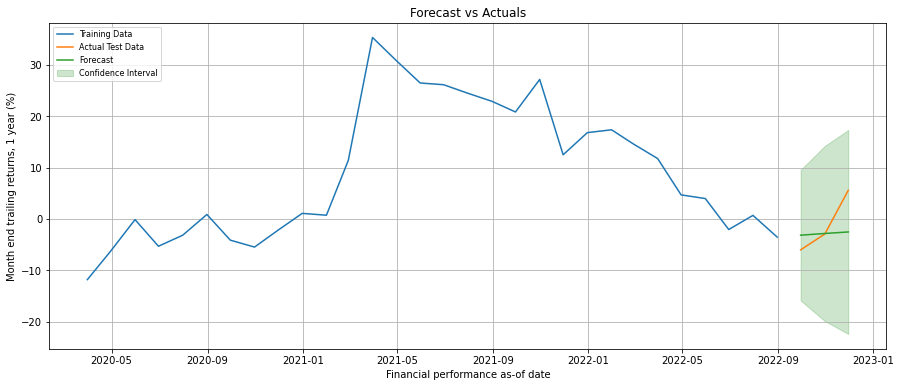

Actual value: Financial performance as-of date
2022-09-30   -6.01302
2022-10-31   -2.94091
2022-11-30    5.56978
Name: Month end trailing returns, 1 year, dtype: float64
Forecasted value: 2022-09-30   -3.166205
2022-10-31   -2.833560
2022-11-30   -2.535864
Freq: M, dtype: float64
95% Confidence interval: [[-15.86553713   9.53312738]
 [-19.87583672  14.20871595]
 [-22.38253614  17.31080844]]
MAPE: 65.50779210735183
1
BlackRock Global Dividend Inv A
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=253.322, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=211.753, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=232.324, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=262.055, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=213.716, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=213.723, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.

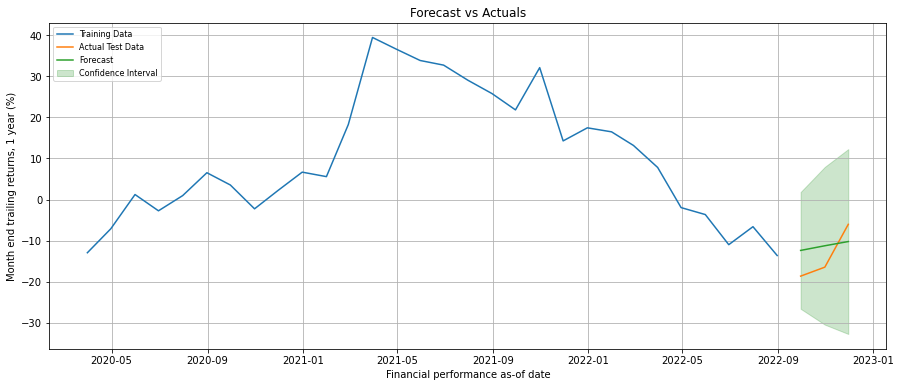

Actual value: Financial performance as-of date
2022-09-30   -18.64982
2022-10-31   -16.46266
2022-11-30    -6.03591
Name: Month end trailing returns, 1 year, dtype: float64
Forecasted value: 2022-09-30   -12.389174
2022-10-31   -11.256204
2022-11-30   -10.226842
Freq: M, dtype: float64
95% Confidence interval: [[-26.60299187   1.82464486]
 [-30.46046661   7.94805916]
 [-32.73167677  12.27799238]]
MAPE: 44.87621211636068
2
Brown Advisory Sustainable Growth Adv
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=227.670, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=217.747, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=209.719, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=209.762, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=208.512, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=209.

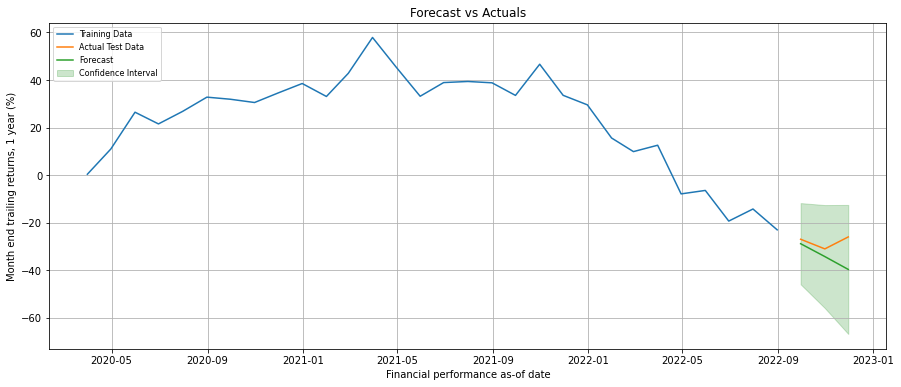

Actual value: Financial performance as-of date
2022-09-30   -26.99743
2022-10-31   -31.05420
2022-11-30   -26.01795
Name: Month end trailing returns, 1 year, dtype: float64
Forecasted value: 2022-09-30   -28.870548
2022-10-31   -34.285994
2022-11-30   -39.701440
Freq: M, dtype: float64
95% Confidence interval: [[-45.96036761 -11.78072748]
 [-55.95581293 -12.61617426]
 [-66.85319244 -12.54968685]]
MAPE: 23.312525108917516
3
Columbia Emerging Markets Adv
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=223.459, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=222.466, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=220.797, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=221.969, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=220.625, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=221.797, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.128 seconds


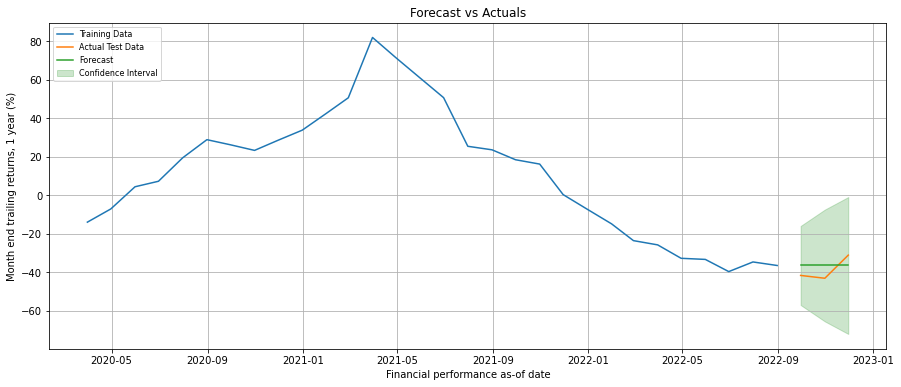

Actual value: Financial performance as-of date
2022-09-30   -41.68038
2022-10-31   -43.15039
2022-11-30   -31.11393
Name: Month end trailing returns, 1 year, dtype: float64
Forecasted value: 2022-09-30   -36.51508
2022-10-31   -36.51508
2022-11-30   -36.51508
Freq: M, dtype: float64
95% Confidence interval: [[-57.07605919 -15.95410081]
 [-65.59269562  -7.43746438]
 [-72.12774061  -0.90241939]]
MAPE: 15.043026822289843
4
Fidelity Growth & Income K
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=270.129, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=228.119, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=284.283, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=229.719, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=229.732, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 se

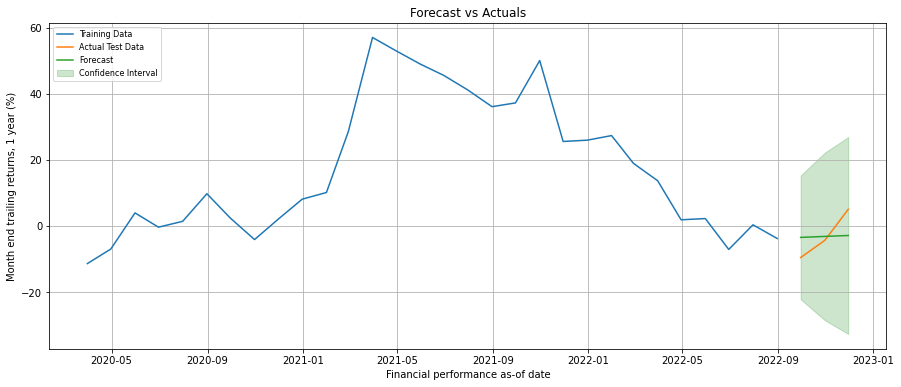

Actual value: Financial performance as-of date
2022-09-30   -9.59366
2022-10-31   -4.36875
2022-11-30    5.02915
Name: Month end trailing returns, 1 year, dtype: float64
Forecasted value: 2022-09-30   -3.481309
2022-10-31   -3.180398
2022-11-30   -2.905497
Freq: M, dtype: float64
95% Confidence interval: [[-22.22294397  15.26032629]
 [-28.56545001  22.20465382]
 [-32.72269341  26.91169959]]
MAPE: 82.89557006804161
5
First Eagle Global I
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=247.775, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=204.409, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=258.009, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=205.474, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=205.496, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(1

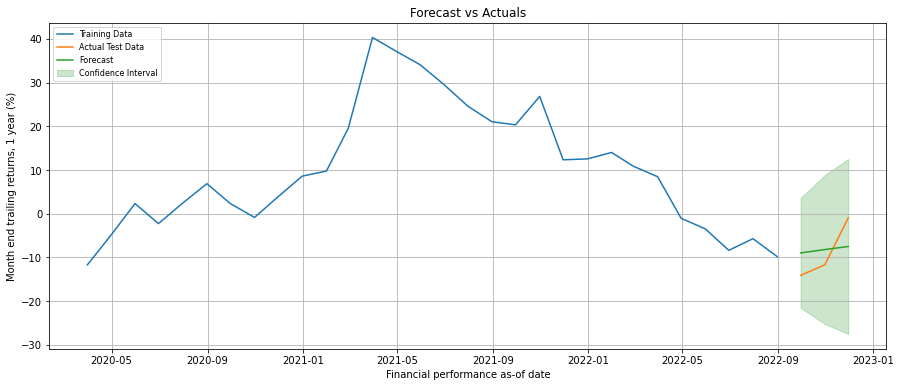

Actual value: Financial performance as-of date
2022-09-30   -14.10046
2022-10-31   -11.68819
2022-11-30    -0.94397
Name: Month end trailing returns, 1 year, dtype: float64
Forecasted value: 2022-09-30   -8.972544
2022-10-31   -8.206805
2022-11-30   -7.506416
Freq: M, dtype: float64
95% Confidence interval: [[-21.53762179   3.59253475]
 [-25.23514412   8.82153494]
 [-27.51803497  12.50520357]]
MAPE: 253.78297926566006
6
Franklin Utilities Adv
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=196.323, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=196.312, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=194.928, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=194.521, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.191 seconds


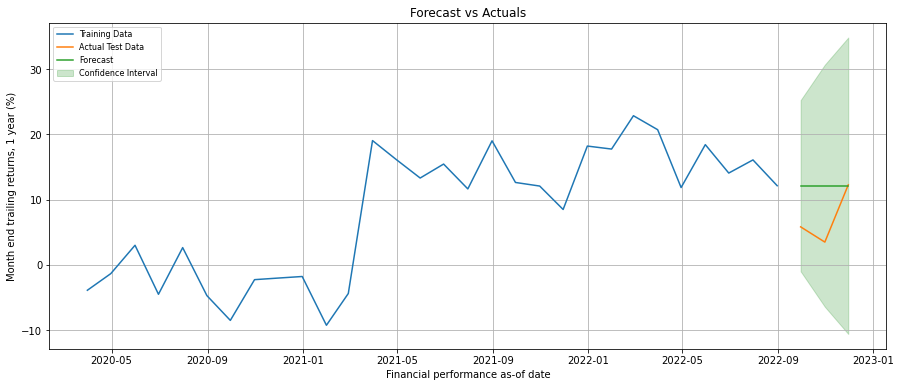

Actual value: Financial performance as-of date
2022-09-30     5.81965
2022-10-31     3.48384
2022-11-30    12.25506
Name: Month end trailing returns, 1 year, dtype: float64
Forecasted value: 2022-09-30    12.11811
2022-10-31    12.11811
2022-11-30    12.11811
Freq: M, dtype: float64
95% Confidence interval: [[ -0.99144176  25.22766176]
 [ -6.4215959   30.6578159 ]
 [-10.58829971  34.82451971]]
MAPE: 119.06089969758824
7
SEI Tax-Managed Large Cap F (SIMT)
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=264.718, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=223.501, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=280.386, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=225.350, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=225.359, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time

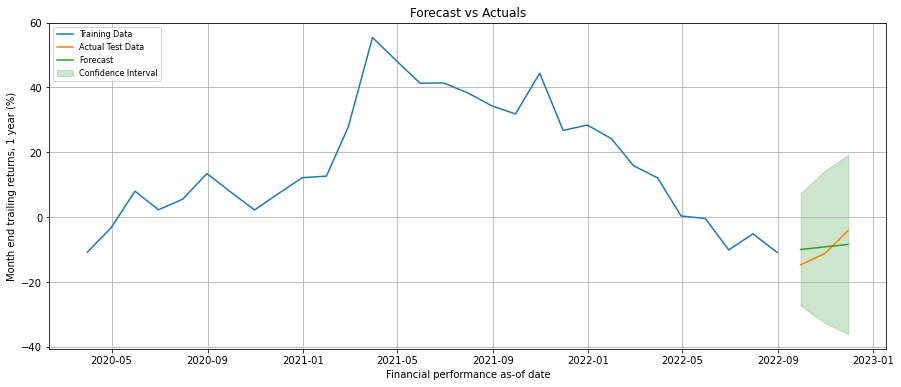

Actual value: Financial performance as-of date
2022-09-30   -14.71620
2022-10-31   -11.21781
2022-11-30    -4.07741
Name: Month end trailing returns, 1 year, dtype: float64
Forecasted value: 2022-09-30   -9.992096
2022-10-31   -9.169573
2022-11-30   -8.414758
Freq: M, dtype: float64
95% Confidence interval: [[-27.29497561   7.31078403]
 [-32.65399513  14.3148492 ]
 [-36.05252006  19.22300398]]
MAPE: 52.24508649996237
8
Vanguard Value Index I
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=266.587, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=223.041, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=277.740, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=224.740, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=224.751, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 AR

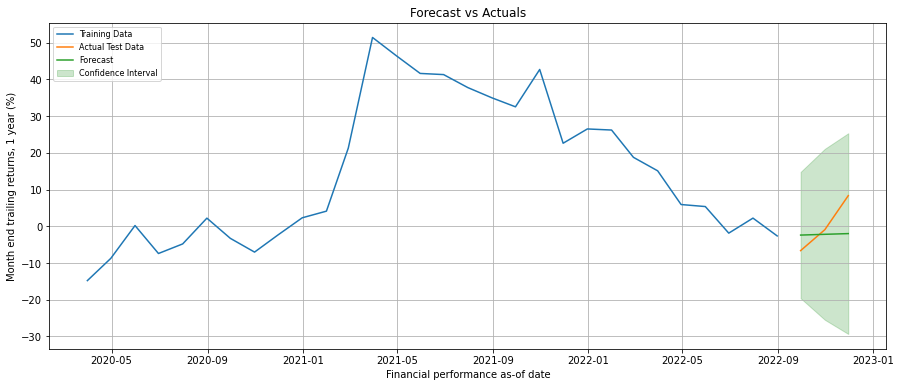

Actual value: Financial performance as-of date
2022-09-30   -6.62917
2022-10-31   -0.93067
2022-11-30    8.33728
Name: Month end trailing returns, 1 year, dtype: float64
Forecasted value: 2022-09-30   -2.400064
2022-10-31   -2.190015
2022-11-30   -1.998348
Freq: M, dtype: float64
95% Confidence interval: [[-19.58767074  14.78754232]
 [-25.4576346   21.07760509]
 [-29.31466207  25.31796515]]
MAPE: 107.69338761590606
9
iShares Russell Top 200 ETF
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=259.774, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=223.184, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=283.198, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=225.178, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=225.177, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec


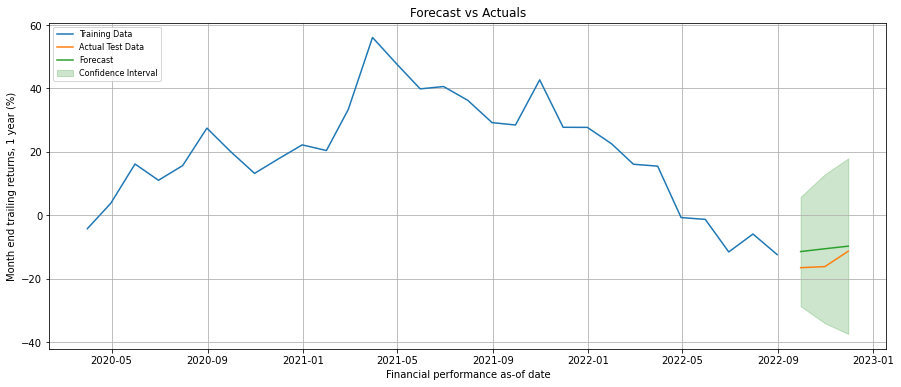

Actual value: Financial performance as-of date
2022-09-30   -16.55073
2022-10-31   -16.21483
2022-11-30   -11.35750
Name: Month end trailing returns, 1 year, dtype: float64
Forecasted value: 2022-09-30   -11.465876
2022-10-31   -10.581139
2022-11-30    -9.764671
Freq: M, dtype: float64
95% Confidence interval: [[-28.71894302   5.78719039]
 [-34.05817584  12.89589689]
 [-37.46054899  17.93120653]]
MAPE: 26.49712143012179


In [26]:
# Call the function on these 10 time series 
shareclass_names_arima = ts_10['Shareclass_name'].unique()
n = len(shareclass_names_arima)

pred_arima = [0]*n
mape_arima = [0]*n

output_arima = []

for i in range(10):
    print(i)
    shareclass_name = shareclass_names_arima[i]
    print(shareclass_name)
    ts = ts_10.loc[ts_10['Shareclass_name']==shareclass_name, 'Month end trailing returns, 1 year']
    pred_arima[i], mape_arima[i] = evaluate_arima(ts, forecast_horizon, plot = True, verbose = True)
    output = (shareclass_name, pred_arima[i], mape_arima[i])
    output_arima.append(output)
    

In [27]:
output_arima_df = pd.DataFrame(output_arima, columns = ['shareclass_names', 'pred_arima', 'mape_arima'])
output_arima_df

,shareclass_names,pred_arima,mape_arima
0,American Century Equity Income Inv,2022-09-30 -3.166205 2022-10-31 -2.833560 ...,65.507792
1,BlackRock Global Dividend Inv A,2022-09-30 -12.389174 2022-10-31 -11.25620...,44.876212
2,Brown Advisory Sustainable Growth Adv,2022-09-30 -28.870548 2022-10-31 -34.28599...,23.312525
3,Columbia Emerging Markets Adv,2022-09-30 -36.51508 2022-10-31 -36.51508 ...,15.043027
4,Fidelity Growth & Income K,2022-09-30 -3.481309 2022-10-31 -3.180398 ...,82.895570
5,First Eagle Global I,2022-09-30 -8.972544 2022-10-31 -8.206805 ...,253.782979
6,Franklin Utilities Adv,2022-09-30 12.11811 2022-10-31 12.11811 ...,119.060900
7,SEI Tax-Managed Large Cap F (SIMT),2022-09-30 -9.992096 2022-10-31 -9.169573 ...,52.245086
8,Vanguard Value Index I,2022-09-30 -2.400064 2022-10-31 -2.190015 ...,107.693388
9,iShares Russell Top 200 ETF,2022-09-30 -11.465876 2022-10-31 -10.58113...,26.497121


[Back to the Table of Contents](#0)

<a id="5"></a> 
## Building the Functions for Random Forest Model

<a id="5.1"></a> 
### Make a Function of the Regression Problem

In [28]:
# Build a regression problem for a given time series and other parameters using lagging windows

# for aggregation functions, define mean and std
def mean(array):
    avg = statistics.mean(array)
    return avg
def std(array):
    std = statistics.stdev(array)
    return std

# defind the regression problem
def regression_problem(ts_df: pd.DataFrame, target_name: str, window_size: int, num_windows: int,
                       aggregation_functions: list) -> pd.DataFrame:
    # ts_df is the dataframe including the time series of the target and all the features
    # target_name is the column name corresponding to the target in the dataframe ts_df
    # window_size is the number of time steps in the window
    # num_windows is the number of times the lagging window will be moved in the past
    # aggregation_functions are a list of function objects that map floats to floats, including options of mean, max, min, std
    
    target = ts_df[target_name]
    features = ts_df.drop(target_name, axis = 1)
    
    # For the target and each numeric feature, generate new features: 
    # Save a copy to add all the new features
    ts_df_extd = ts_df.copy()
    
    # The loop to generate the new features
    # For the target, generate the following features: 
    # lagging variables based on window_size and num_window
    # moving average of the target based on window_size and num_window
    # Note that variables based on target cannot include the current time step
    for i in range(1, num_windows + 1):
        # lagging variables
        ts_df_extd[f'{target_name}_{window_size}_month_lag_{i}_times'] =  target.shift(window_size*i)
        for j in aggregation_functions:
            ts_df_extd[f'{target_name}_moving_{j.__name__}_{window_size}_month_lag_{i}_times'] = target.shift(1).rolling(window = window_size*i).apply(j)
            
    # Preprocess the categorical features
    categ_columns = features.select_dtypes(include=['object']).columns    
    encoder = OrdinalEncoder(categories=[ordinal_categories] * len(categ_columns))
    # Apply encoding to selected ordinal columns
    ts_df_extd[categ_columns] = encoder.fit_transform(ts_df_extd[categ_columns])
    
    return ts_df_extd

[Back to the Table of Contents](#0)

<a id="5.2"></a> 
### Make a Function to Apply Regression Algorithms on the Problem

In [29]:
# Given a regression problem, a target name, and a forecasting horizon;
# applies regression algorithm to the regression problems,
# and outputs the predictions, and performance metrics

# firstly, using random forest model, expand to others in the future

def apply_regression(data: pd.DataFrame, target_name: str, forecasting_horizon: int):
    # data is the regression problem
    data.dropna(inplace = True)
    train = data.iloc[:-forecasting_horizon]
    test  = data.iloc[-forecasting_horizon:]
    features = train.columns[train.columns != target_name]
    # modeling
    model = RandomForestRegressor(n_estimators = 100, random_state = 42)
    model.fit(train[features], train[target_name])
    # prediction
    predictions = model.predict(test[features])
    # evaluate model performance using the MAPE as the metrics
    mape = (np.abs((test[target_name] - predictions)/test[target_name])).mean()*100
    
    return predictions, mape

[Back to the Table of Contents](#0)

<a id="5.3"></a> 
### Apply the Functions on the Time Series

In [30]:
# Applied on the same 10 times series with features
# iterates on these time series and applies the functions above

shareclass_names = model_data.index.get_level_values(0).unique()
n = len(shareclass_names)

pred_rf = [0]*n
mape_rf = [0]*n

output_rf = []

for i in range(n):
    print(shareclass_names[i])
    reg_prb = regression_problem(ts_df = model_data.loc[shareclass_names[i]],
                                 target_name = 'Month end trailing returns, 1 year', 
                                 window_size = 3, num_windows = 2, aggregation_functions = [mean, std, max, min])
    pred_rf[i], mape_rf[i] = apply_regression(data = reg_prb, 
                                         target_name = 'Month end trailing returns, 1 year',
                                         forecasting_horizon = 3)
    output = (shareclass_names[i], pred_rf[i], mape_rf[i])
    output_rf.append(output)
    print(pred_rf[i])
    print(mape_rf[i])

American Century Equity Income Inv
[-1.10058175 -1.28529675 -0.9385019 ]
84.94751055617093
BlackRock Global Dividend Inv A
[-8.5089324 -7.0959442  4.2819476]
94.071067003039
Brown Advisory Sustainable Growth Adv
[-13.9274537  -11.3954697  -11.94909135]
55.26338967838909
Columbia Emerging Markets Adv
[-24.8727533 -27.2535266 -31.4252697]
26.05542609801455
Fidelity Growth & Income K
[ 3.4011191 -1.0445146  3.5713717]
80.17651210901663
First Eagle Global I
[-3.7502781   0.7690137  -4.15276795]
173.30279947128835
Franklin Utilities Adv
[14.3320333  15.76081165 16.20506105]
176.96631989447036
SEI Tax-Managed Large Cap F (SIMT)
[-2.1391743  -3.92833425 -1.8340995 ]
68.48770419340705
Vanguard Value Index I
[ 3.61436375  5.83851    12.8784438 ]
312.11170048866444
iShares Russell Top 200 ETF
[-5.15036185 -7.1808354  -6.05464395]
57.09536782405383


In [31]:
output_rf_df = pd.DataFrame(output_rf, columns = ['shareclass_names', 'pred_rf', 'mape_rf'])
output_rf_df

,shareclass_names,pred_rf,mape_rf
0,American Century Equity Income Inv,"[-1.1005817499999986, -1.2852967499999988, -0....",84.947511
1,BlackRock Global Dividend Inv A,"[-8.50893239999999, -7.0959441999999955, 4.281...",94.071067
2,Brown Advisory Sustainable Growth Adv,"[-13.927453700000008, -11.395469700000001, -11...",55.263390
3,Columbia Emerging Markets Adv,"[-24.872753300000003, -27.253526600000004, -31...",26.055426
4,Fidelity Growth & Income K,"[3.4011190999999985, -1.0445145999999985, 3.57...",80.176512
5,First Eagle Global I,"[-3.7502781, 0.7690136999999991, -4.1527679499...",173.302799
6,Franklin Utilities Adv,"[14.332033299999992, 15.76081165, 16.20506105]",176.966320
7,SEI Tax-Managed Large Cap F (SIMT),"[-2.139174299999998, -3.9283342499999976, -1.8...",68.487704
8,Vanguard Value Index I,"[3.61436375, 5.8385099999999985, 12.8784437999...",312.111700
9,iShares Russell Top 200 ETF,"[-5.150361850000004, -7.180835399999999, -6.05...",57.095368


[Back to the Table of Contents](#0)

<a id="5.4"></a> 
### Compare the Outputs from ARIMA Model and Random Forest Model

In [32]:
output_df = pd.merge(output_arima_df, output_rf_df, on='shareclass_names')

In [33]:
output_df = output_df.set_index('shareclass_names')

In [34]:
output_df['mape_diff(arima-rf)'] = output_df['mape_arima'] - output_df['mape_rf']

In [35]:
table = output_df.filter(like = 'mape')
table

,mape_arima,mape_rf,mape_diff(arima-rf)
shareclass_names,,,
American Century Equity Income Inv,65.507792,84.947511,-19.439718
BlackRock Global Dividend Inv A,44.876212,94.071067,-49.194855
Brown Advisory Sustainable Growth Adv,23.312525,55.263390,-31.950865
Columbia Emerging Markets Adv,15.043027,26.055426,-11.012399
Fidelity Growth & Income K,82.895570,80.176512,2.719058
First Eagle Global I,253.782979,173.302799,80.480180
Franklin Utilities Adv,119.060900,176.966320,-57.905420
SEI Tax-Managed Large Cap F (SIMT),52.245086,68.487704,-16.242618
Vanguard Value Index I,107.693388,312.111700,-204.418313


In [36]:
len(output_df.loc[output_df['mape_diff(arima-rf)'] < 0, :])

8

In [37]:
table.rename(columns={'mape_arima': 'ARIMA MAPE', 
                          'mape_rf': 'Random Forest MAPE', 
                          'mape_diff(arima-rf)': 'ARIMA MAPE - Random Forest MAPE'}, 
                 inplace=True)

In [38]:
table.index.name = 'Fund Share Class Name'

In [39]:
table_rounded = table.round(2)
table_rounded

,ARIMA MAPE,Random Forest MAPE,ARIMA MAPE - Random Forest MAPE
Fund Share Class Name,,,
American Century Equity Income Inv,65.51,84.95,-19.44
BlackRock Global Dividend Inv A,44.88,94.07,-49.19
Brown Advisory Sustainable Growth Adv,23.31,55.26,-31.95
Columbia Emerging Markets Adv,15.04,26.06,-11.01
Fidelity Growth & Income K,82.90,80.18,2.72
First Eagle Global I,253.78,173.30,80.48
Franklin Utilities Adv,119.06,176.97,-57.91
SEI Tax-Managed Large Cap F (SIMT),52.25,68.49,-16.24
Vanguard Value Index I,107.69,312.11,-204.42


In [40]:
table_rounded.to_csv('MAPE of ARIMA and Random Forest Models Comparison.csv')

Comparing the MAPE values from the ARIMA model to the ones from the Random Forest model, we can see that most of the time (8 out of 10), the ARIMA model outperforms the Random Forest model. Only for Fidelity Growth & Income K and First Eagle Global I do the random forest models outperform the ARIMA models. The performance of these models also differs for different funds. The ARIMA model performs worst for First Eagle Global I, and the Random Forest model performs worst for Vanguard Value Index I. They both perform best for Columbia Emerging Markets Adv.

[Back to the Table of Contents](#0)

<a id="6"></a> 
## Summary

In this section, we write functions to forecast time series using ARIMA and Random Forest models. We can apply these functions to any funds of interest in the dataset to predict their future financial performance and evaluate the predictions. For example, we applied them to ten randomly selected funds and compared their performances. The results indicate that the ARIMA models outperform the Random Forest models in general based on our settings. However, the Random Forest models have many aspects to improve, such as adding relevant features and finding more useful lagging windows and aggregation functions. In the next step, we can also use other regression models to see how the regression model choice impacts the results. The functions make exploring the best models feasible and straightforward.

[Back to the Table of Contents](#0)